In [ ]:
#Import Libraries 

import re
import pandas as pd
from matplotlib import pyplot
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

sns.set()
%matplotlib inline

In [ ]:
#Import Data
df_train = pd.read_csv('drive/Shared drives/House_Prices/train.csv')
df_test = pd.read_csv('drive/Shared drives/House_Prices/test.csv')

# Data Prep, Dropping NAs


In [ ]:
#delete columns with many missing data
df_train.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage'], axis = 1,inplace=True)

#Drop rows with missing data 
df_train.dropna(inplace=True)
df_train.shape

NameError: ignored

In [ ]:
df_train.isnull().sum().max() #just checking that there's no missing data missing...

0

In [ ]:
from sklearn.model_selection import train_test_split
df_train = pd.get_dummies(df_train)
X_train, X_test, y_train, y_test = train_test_split(df_train.loc[:, df_train.columns != 'SalePrice'], df_train['SalePrice'], test_size=0.25, random_state=42)

# Feel free to start building your models now

Let me know if you need any help !! 

# PCA Decomposition


In [ ]:
#Creating Price Categories for TSNE and PCA Visualization!! We may want to use
#this in training classification models as well
def what_bracket(sale_price):
  if sale_price <=100000:
    return "Tier 1"
  elif sale_price <=200000:
    return "Tier 2"
  elif sale_price <=300000:
    return "Tier 3"
  elif sale_price <= 500000:
    return "Tier 4"
  else:
    return "Tier 5"

y_tiers = y_train.apply(what_bracket)

In [ ]:
#Here I decompose each image into 50 principal components
from sklearn.decomposition import PCA

def pca_dec(data, n):
  pca = PCA(n)
  X_dec = pca.fit_transform(data)
  return X_dec, pca

#Decomposing the train set:
pca_train_results, pca_train = pca_dec(X_train, 10)

#Decomposing the test set:
pca_test_results, pca_test = pca_dec(X_test, 10)

#Creating a table with the explained variance ratio
names_pcas = [f"PCA Component {i}" for i in range(1, 11, 1)]
scree = pd.DataFrame(list(zip(names_pcas, pca_train.explained_variance_ratio_)), columns=["Component", "Explained Variance Ratio"])
print(scree)

          Component  Explained Variance Ratio
0   PCA Component 1                  0.985988
1   PCA Component 2                  0.004436
2   PCA Component 3                  0.003187
3   PCA Component 4                  0.002591
4   PCA Component 5                  0.001587
5   PCA Component 6                  0.000903
6   PCA Component 7                  0.000401
7   PCA Component 8                  0.000240
8   PCA Component 9                  0.000189
9  PCA Component 10                  0.000181


Text(0, 0.5, 'Explained Variance Ratio')

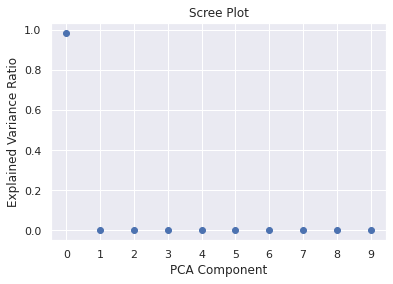

In [ ]:
#Creating a scree plot:
xs = np.linspace(0, 9, 10)

plt.scatter(xs, pca_train.explained_variance_ratio_)
plt.title("Scree Plot")
plt.xlabel("PCA Component")
plt.xticks(ticks=xs)
plt.ylabel("Explained Variance Ratio")

Text(0, 0.5, 'PCA Component 2')

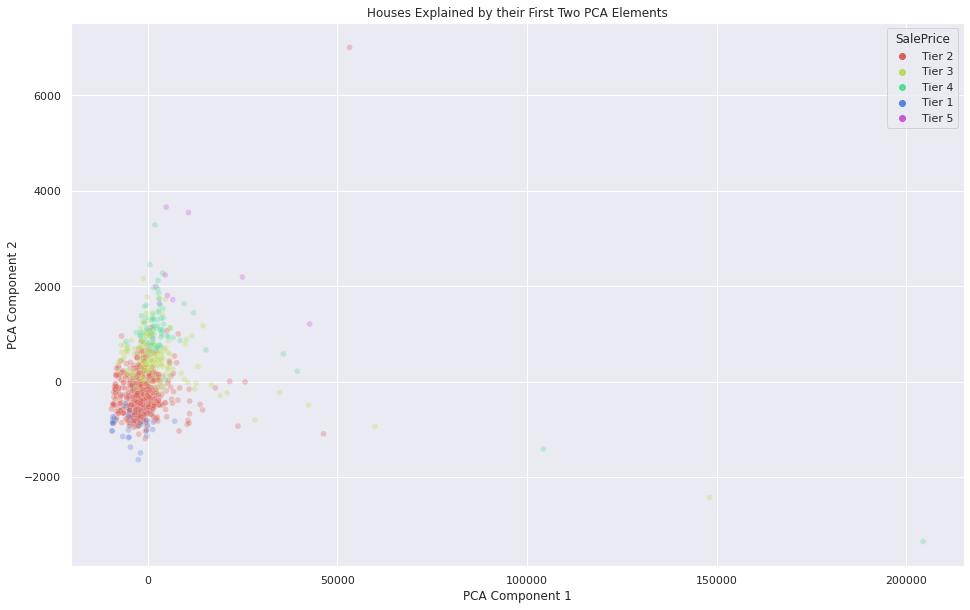

In [ ]:
#Plotting the first two PCA components, as well as the price tier of the house
#to see if PCA helps us distinguish price-points

import seaborn as sns
import matplotlib.pyplot as plt

first_comps = pca_train_results[:,0] #Taking the first PCA component for each
                                    #decomposed house's data

second_comps = pca_train_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=first_comps, y=second_comps,
    hue=y_tiers,
    palette=sns.color_palette("hls", 5),
    legend="full",
    alpha=0.3
)

plt.title("Houses Explained by their First Two PCA Elements")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")


## Looking Closely at the First Principal Component

In [ ]:
#Sorting the values of the first principal component by how large each one is
df = pd.DataFrame({'PCA':pca_train.components_[0], 'Variable Names':list(X_train.columns)})
df = df.sort_values('PCA', ascending=False)

#Sorting the absolute values of the first principal component by magnitude
df2 = pd.DataFrame(df)
df2['PCA']=df2['PCA'].apply(np.absolute)
df2 = df2.sort_values('PCA', ascending=False)
print(df2['Variable Names'][0:11])

2         LotArea
15      GrLivArea
12       1stFlrSF
11    TotalBsmtSF
8      BsmtFinSF1
26     GarageArea
9      BsmtFinSF2
7      MasVnrArea
13       2ndFlrSF
27     WoodDeckSF
0              Id
Name: Variable Names, dtype: object


In [ ]:
df.head()

,PCA,Variable Names
2,0.999730,LotArea
15,0.013377,GrLivArea
12,0.011297,1stFlrSF
11,0.010933,TotalBsmtSF
8,0.009208,BsmtFinSF1


The variables printed above are the largest contributors to the first principal components, and thus can be seen as the variables that best explain the variance in the data. Lot Area in particular has a very high influence, at 99.9%. The second most influential variable is Ground Living Area, how much area there is above ground, which is at around 1.2%. Furthermore, note that the first principal component corresponds to 99% of the variance of the data, and therefore that Lot Area is by far the most important variable in determining the variance. This makes a lot of sense intuitively: larger lot areas mean more space for all other factors like pools, garages, rooms, basements, etc.

## Looking Closely at the Second Principal Component

In [ ]:
#Sorting the values of the first principal component by how large each one is
df = pd.DataFrame({'PCA':pca_train.components_[1], 'Variable Names':list(X_train.columns)})
df = df.sort_values('PCA', ascending=False)

#Sorting the absolute values of the first principal component by magnitude
df2 = pd.DataFrame(df)
df2['PCA']=df2['PCA'].apply(np.absolute)
df2 = df2.sort_values('PCA', ascending=False)
print(df2['Variable Names'][0:11])

15      GrLivArea
11    TotalBsmtSF
12       1stFlrSF
8      BsmtFinSF1
13       2ndFlrSF
10      BsmtUnfSF
26     GarageArea
7      MasVnrArea
27     WoodDeckSF
28    OpenPorchSF
2         LotArea
Name: Variable Names, dtype: object


In [ ]:
df.head()

,PCA,Variable Names
15,0.636707,GrLivArea
11,0.452011,TotalBsmtSF
12,0.437619,1stFlrSF
8,0.274906,BsmtFinSF1
13,0.197455,2ndFlrSF


We can see that, now that the first component has accounted for the importance of living area, other components like ground living area nad total basement area look to be given more importance.

# TSNE Decomposition

In [ ]:
from sklearn.manifold import TSNE

#Decomposing the data with TSNE, onto 2 dimensions
tsne_train = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_train_results = tsne_train.fit_transform(foo)

tsne_test = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_test_results = tsne_test.fit_transform(foo_test)

Text(0.5, 1.0, 'T-SNE Decomposed Data')

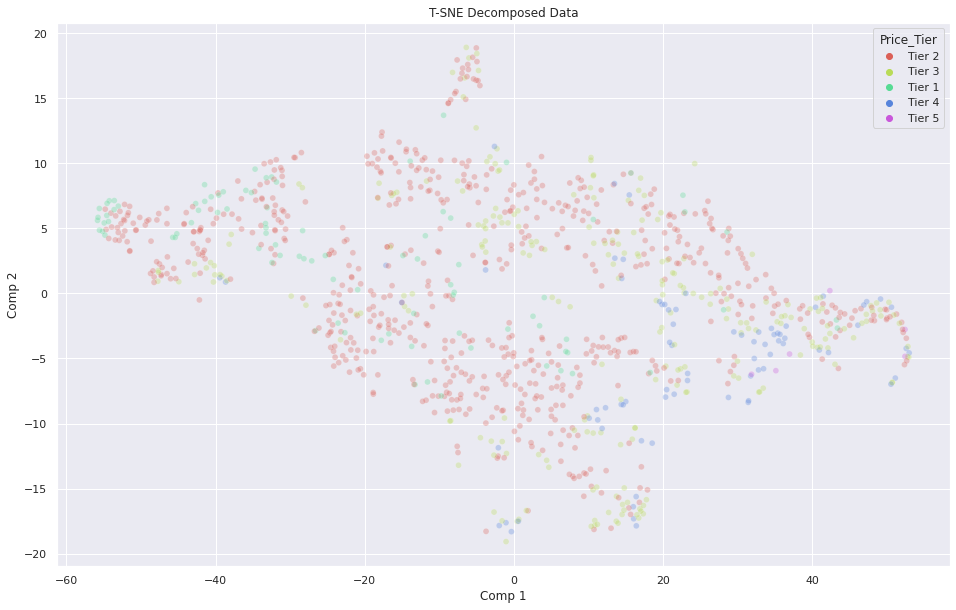

In [ ]:
#Plotting the data as explained by the two TSNE components
first_tsne = tsne_train_results[:,0]
second_tsne = tsne_train_results[:,1]

import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(16,10))
sns.scatterplot(
    x=first_tsne, y=second_tsne,
    hue=y_train["Price_Tier"],
    palette=sns.color_palette("hls", 5),
    legend="full",
    alpha=0.3
)
plt.xlabel("Comp 1")
plt.ylabel("Comp 2")
plt.title("T-SNE Decomposed Data")

# Testing Decomposition Performance

## XGBOOST

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

data_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
params = {"objective":'reg:squarederror', "colsample_bytree":0.2, "learning_rate":0.08, "max_depth":4, "alpha":16}
xg_m = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=70)

data_dmatrix_test = xgb.DMatrix(data=X_test)
preds = xg_m.predict(data_dmatrix_test)

def f(x):
  params = {"objective":'reg:squarederror', "colsample_bytree":x[0], "learning_rate":x[1], "max_depth":x[2], "alpha":x[3], "n_boost_round":x[4]}
  
  

  cv_results=xgb.cv(dtrain=data_dmatrix, params=params, nfold=10, num_boost_round=x[4], early_stopping_rounds=10, metrics='rmse', as_pandas=True)
  return cv_results['test-rmse-mean'].min()

np.sqrt(mean_squared_error(preds, y_test))
#f([0.2, 0.07, 4, 16, 70])

32389.117783905178

In [ ]:
np.std(y_train)

83079.35085062851

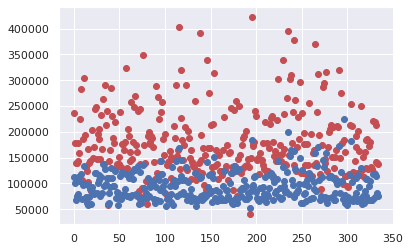

In [ ]:
x = range(335)
plt.plot(x, y_test, 'ro')
plt.plot(x, preds, 'bo')

In [ ]:
x = np.linspace(0, 0.6, num=20)

lst=[]
for i in x:
  lst.append(f([0.2, i, 4, 16, 70]))

Text(0.5, 1.0, 'How does RMSE change with inceasing Learning Rate?')

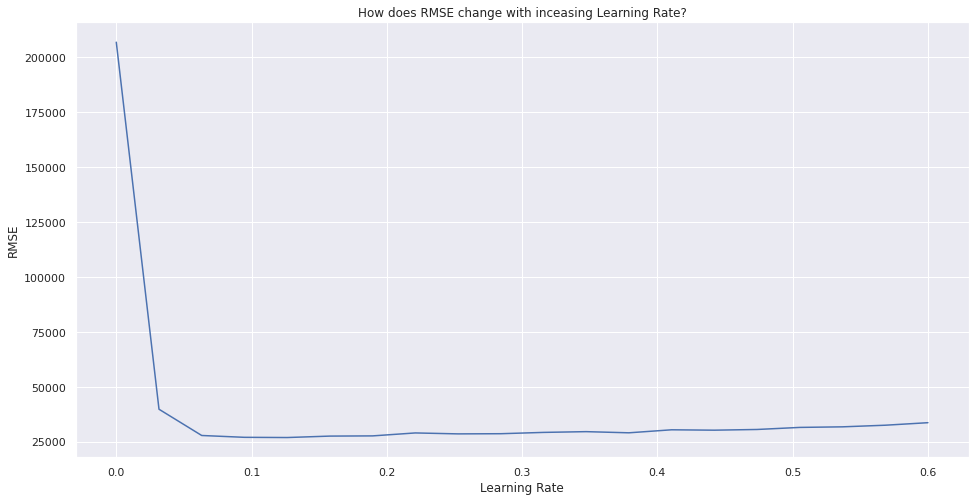

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(x, lst)
plt.xlabel("Learning Rate")
plt.ylabel("RMSE")
plt.title("How does RMSE change with inceasing Learning Rate?")

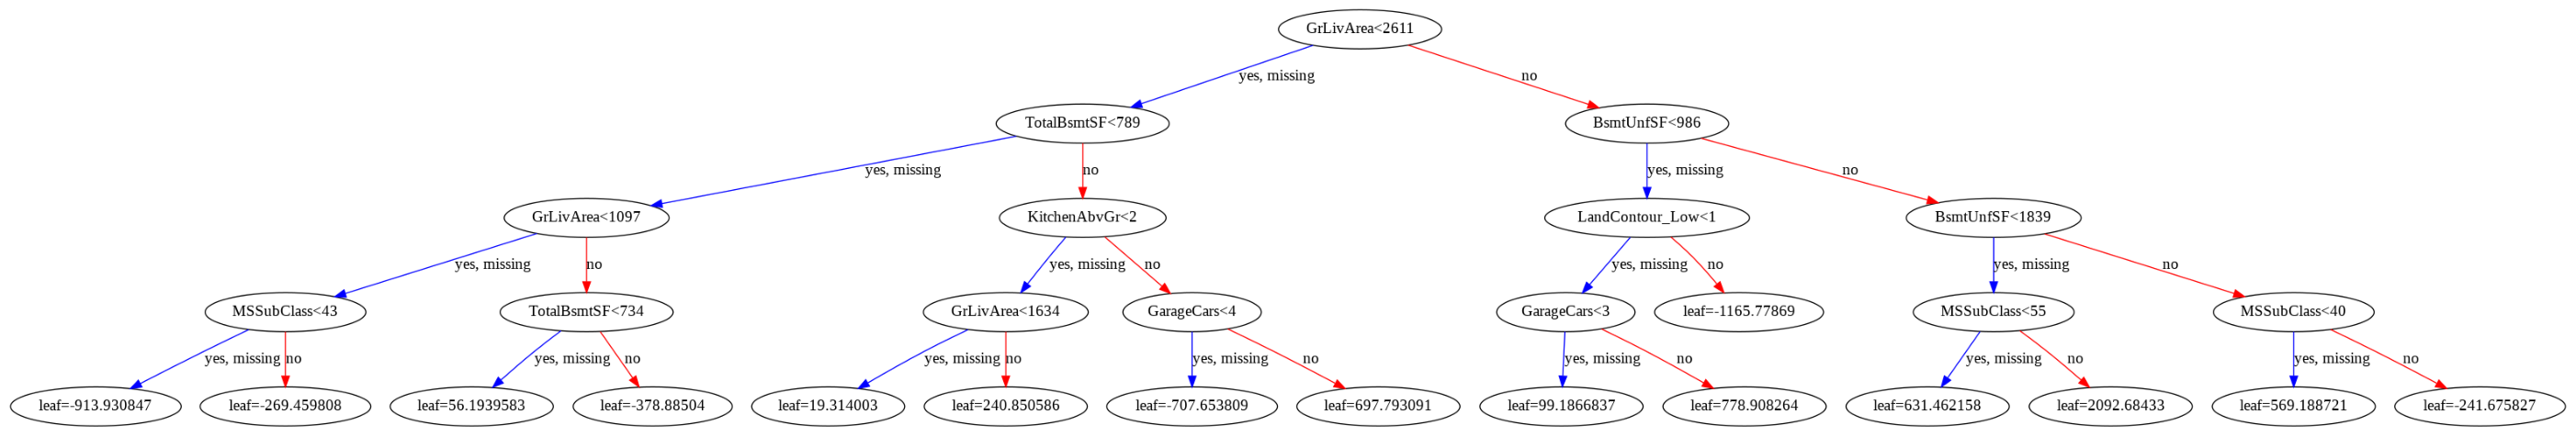

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_m,num_trees=69)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

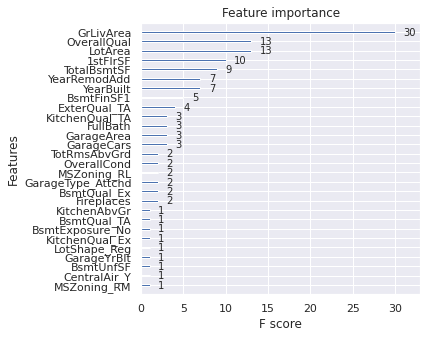

In [ ]:
xgb.plot_importance(xg_m)
plt.rcParams['figure.figsize'] = [1, 1]
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## SVR Model - PCA

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error

PCA_SVR_model = SVR()
PCA_SVR_model.fit(pca_train_results, y_train['SalePrice'])

y_pred = PCA_SVR_model.predict(pca_test_results)
print(mean_squared_error(y_test, y_pred))

7184007266.223966


## SVR Model - TSNE

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score

TSNE_SVR_model = SVR()
TSNE_SVR_model.fit(tsne_train_results, y_train['SalePrice'])

y_pred = TSNE_SVR_model.predict(tsne_test_results)
print(mean_squared_error(y_test, y_pred))

7181736335.132636


In [ ]:
type(y_test)


pandas.core.series.Series

### Important PCA and TSNE related variables I produced:
- pca_train_results: this represents the around 1000 houses now described by 10 features (the 10 Principal Components). This is an ndarray of shape (1095, 10).
- y_train: this is a Data Frame with two columns: first, the "Sale Price" corresponding to the sale price of the houses in the pca_train_results and tsne_train_results data. The second column, "Price_Tier", is a classification of the prices into 5 tiers ranging from chapest "Tier 1" to most expensive "Tier 5".
- tsne_train_results: this represents the around 1000 houses now described by 2 featers (the two components of the TSNE decomposition). This is an ndarray of shape (1095, 2).
- pca_test_results: this is the pca-decomposed test set data. It is an ndarray of shape (365, 10).
- tsne_test_results: this is the tsne-decomposed test set data. It is an ndarray of shape (365, 2).
- y_test: this is a pandas series object with the prices for the houses in the pca_test_results and tsne_test_results data.

Also note: I left the df_train and df_test dataframes, with all the original data Ahmed was using, untouched and unchanged in case you want to look at the original data!